In [21]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

Defining the Objective Function and the Inequality Constraints

In [22]:

o = lambda x: x[0]**2 + (x[1] - 3)**2
g_1 = lambda x: x[1]**2 - 2*x[0]
g_2 = lambda x: (x[1]-1)**2 + 5*x[0]-15
fo  = lambda x : torch.tensor([[2 * x[0], 2 * (x[1] - 3)]])
fg_1 = lambda x : torch.tensor([[-2, 2 * x[1]]])
fg_2 = lambda x: torch.tensor([[5, 2 * (x[1] - 1)]])

Defining the Necessary Functions

In [23]:

def w_m_fn(Lambda, weights,k):
  if k > 0:
    weights = torch.max(abs(Lambda), 0.5 *(weights + abs(Lambda)))
  else:
    weights = abs(Lambda)
  return weights

In [24]:

def F_a(x,weights,alpha,s):
  c_1=max(0, g_1(x + alpha*s)) # constrain 1
  c_2=max(0, g_2(x + alpha*s)) # constrain 2
  return o(x + alpha*s) +  weights[0,:] * c_1 + weights[1,:]* c_2

Defining the Line-Search **Method**

In [25]:

def lineSearch(x,Lambda,weights,s,k):
    t = 0.3
    alpha = 1
    weights = w_m_fn(Lambda, weights,k)
    if g_1(x) <= 0:
       dg_1_da = 0
    else:
      dg_1_da= torch.matmul(fg_1(x), s)

    if g_2(x) <= 0:
       dg_2_da = 0
    else:
      dg_2_da= torch.matmul(fg_2(x), s)

    dF_da = torch.matmul(fo(x), s) + (weights[0, :] * dg_1_da + weights[1, :] * dg_2_da)

    phi = lambda x, weights, alpha, t, dF_da: F_a(x, weights, 0, 0) + alpha * t * dF_da

    while phi(x, weights, alpha, t, dF_da) < F_a(x, weights, alpha, s):
        alpha = 0.5 * alpha
    return alpha, weights
     

**Defining the BFGS Method**

In [26]:
def BFGS(x,W, s, Lambda, alpha):
  L_xk = fo(x) + torch.matmul(Lambda.T, torch.tensor([g_1(x),g_2(x)]))
  L_xk_1 = fo(x + alpha*s) + torch.matmul(Lambda.T, torch.tensor([g_1(x + alpha*s),g_2(x + alpha*s )]))

  dlt_l = L_xk_1 -L_xk
  
  Q = torch.matmul(torch.matmul((alpha*s).T, W), (alpha*s))
  if torch.matmul((alpha*s).T, dlt_l.T) >= 0.2 * torch.matmul(torch.matmul((alpha*s).T, W), (alpha*s)):
        theta = 1
  else:
        theta = 0.8 * Q / (Q - torch.matmul((alpha*s).T, dlt_l.T))
  y = theta * dlt_l.T + (1 - theta) * torch.matmul(W, (alpha*s))
  W = W + torch.matmul(y, y.T) / torch.matmul(y.T, s) - torch.matmul(torch.matmul(W, s), torch.matmul(s.T, W)) / torch.matmul(torch.matmul(s.T, W), s)
  return W

In [27]:
def L_m_c(Lambda,active):
    Lambda_check = 0
    if len(Lambda) == 0 or min(Lambda) > 0:
        Lambda_check  = 1
    else:
        Lambda_idx = np.argmin(np.array(Lambda))
        Lambda = Lambda[Lambda!=min(Lambda)]
        active.pop(Lambda_idx)
    return active, Lambda_check ,Lambda

**Defining the QP Problem Solver**

In [28]:
def sqp_sol(x, W):
    active = []
    i_A = torch.cat((fg_1(x),fg_2(x)),0)
    B_initial = torch.tensor([[g_1(x), g_2(x)]]).T
    L_i_a = torch.zeros((B_initial.shape[0], 1))
    Lambda = []
    while True:
      if len(active) == 0:
            S_L = torch.matmul(torch.linalg.inv(W), -fo(x).T)
            s = S_L[:2, :]
      if len(active) > 0:
        if len(active) == 1:
                A = i_A[active[0], :].reshape(1, -1)
                B = B_initial[active[0], :].reshape(1,1)
        if len(active) == 2:
                A = i_A
                B = B_initial
                
        Z = torch.zeros((A.shape[0], A.shape[0]))
        matrix=torch.cat((torch.cat((W,A.T),1),torch.cat((A,Z),1)),0)
        j=torch.cat((-fo(x).T,-B),0)
        S_L = torch.matmul(torch.linalg.inv(matrix), j)
        s = S_L[:2, :]
        Lambda = S_L[2:, :]

      if len(Lambda) == 1:
          L_i_a[0] = S_L[2:3, :]
      if len(Lambda) == 2:
          L_i_a[0] = S_L[2:3, :]
          L_i_a[1] = S_L[3:, :]

      sqp_constraint = torch.round((torch.matmul(i_A, s.reshape(-1, 1)) + B_initial))
      active, mu_check,Lambda = L_m_c(Lambda,active)

      if torch.max(sqp_constraint) <= 0 and mu_check == 1:
            return s, L_i_a
      else:
          index = np.argmax(sqp_constraint)
          active.append(index)
          active = np.unique(np.array(active)).tolist()

**SQP Algorithm**

In [29]:
x = torch.tensor([[1,1.]]).T
x_initial = x
Lambda = torch.zeros((x.shape[0], 1))
weights = torch.zeros((x.shape[0], 1))+2
W = torch.eye(x.shape[0])
eps = 1e-4
k = 0

dlt_L_norm = np.linalg.norm(fo(x) + np.matmul(Lambda.T, torch.cat((fg_1(x),fg_2(x)),0)))

while dlt_L_norm > eps:
    s, Lambda = sqp_sol(x, W)
    a, weights = lineSearch(x,Lambda,weights,s,k)
    W = BFGS(x,W, s, Lambda, a) 
    x += a*s
    k += 1
    dlt_L_norm = np.linalg.norm(fo(x) + np.matmul(Lambda.T, torch.cat((fg_1(x),fg_2(x)),0)))

Results

In [44]:
print('Solution of X=({},{})'.format(x[0][0], x[1][0]))
print('The minumim value of objective function = {}'.format(o([x[0][0],x[1][0]])))
print("The inequality constraints=:\ng_1={}\ng_2={}".format(g_1([x[0][0],x[1][0]]),g_2([x[0][0],x[1][0]])))

Solution of X=(1.0602166652679443,1.4561707973480225)
The minumim value of objective function = 3.507467746734619
The inequality constraints=:
g_1=0.0
g_2=-9.490824699401855


**Plotting the Results**

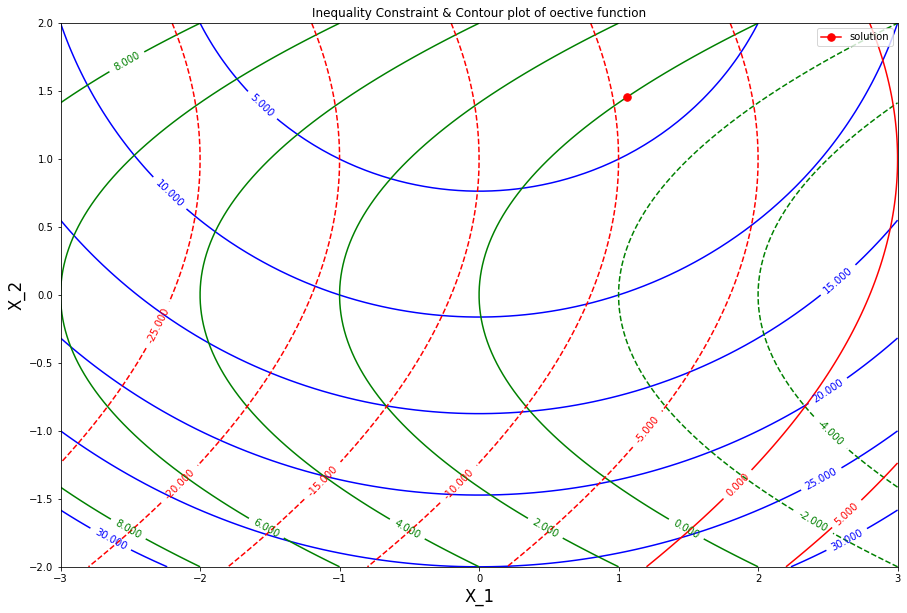

In [43]:
X1 = np.linspace(-3, 3, 100)
X2 = np.linspace(-2, 2, 100)

param_grid = np.array([[C, x2] for x2 in X2 for C in X1])
real = [o(params) for params in param_grid]
e_g1 = [g_1(params) for params in param_grid]
e_g2 = [g_2(params) for params in param_grid]

C, G = np.meshgrid(X1, X2)
fig, ax = plt.subplots(figsize=(15,10))
CS = ax.contour(C, G, np.array(real).reshape(C.shape), colors='b')
ax.clabel(CS, inline=True, fontsize=10)


CS1 = ax.contour(C, G, np.array(e_g1).reshape(C.shape), colors='g')

ax.clabel(CS1, inline=True, fontsize=10)

CS2 = ax.contour(C, G, np.array(e_g2).reshape(C.shape), colors='r')

ax.clabel(CS2, inline=True, fontsize=10)

plt.plot(x[0], x[1], c='red', marker='.', markersize='15', label='solution')
ax.set_xlabel('X_1',fontsize = 16.5)
ax.set_ylabel('X_2',fontsize = 16.5)
plt.legend()
plt.title('Inequality Constraint & Contour plot of oective function')
plt.show()
     